In [1]:
cd kbc

/blue/daisyw/ma.haodi/ComplEx-Inject/kbc


In [2]:
pwd

'/blue/daisyw/ma.haodi/ComplEx-Inject/kbc'

In [3]:
import torch
from models import CP, ComplEx, InjEx
(m,d) = torch.load('/blue/daisyw/ma.haodi/ComplEx-Inject/saved_models/2022-08-08_10-19-35_FB237_InjEx_rule_0.pkl', map_location=torch.device('cpu'))
# (m,d) = torch.load('/blue/daisyw/ma.haodi/ComplEx-Inject/saved_models/2022-08-08_12-09-52_FB237_ComplEx.pkl', map_location=torch.device('cpu'))
# (m,d) = torch.load('/blue/daisyw/ma.haodi/ComplEx-Inject/saved_models/2022-08-08_09-37-15_FB237_InjEx_rule_4.pkl', map_location=torch.device('cpu'))

In [4]:
m

InjEx(
  (embeddings): ModuleList(
    (0): Embedding(14541, 100, sparse=True)
    (1): Embedding(237, 100, sparse=True)
  )
)

In [6]:
def rule_reader(dataset_path, rule_type):
    if rule_type == 0:
        rule_list = []
        rule_list.append(rule_reader(dataset_path, 1))
        rule_list.append(rule_reader(dataset_path, 4))
    elif rule_type == 1:
        kbc_id_conf_f = dataset_path + '/cons.txt'
        rule_list = []
        with open(kbc_id_conf_f, 'r') as f:
            while True:
                line = f.readline()
                if line:
                    flag = 1
                    # two relations split by ',', confidence split by tab
                    line.replace('\n', '')
                    if line[0] == '-': # negative rules
                        flag = -1
                        line = line[1:]
                    tokens = line.split('\t')
                    r_p = int(tokens[0].split(',')[0])
                    r_q = int(tokens[0].split(',')[1])
                    conf = float(tokens[1])
                    # if 0.9 <= conf < 1.0:
                    # if conf == 1.0:
                    rule_list.append((r_p, r_q, conf, flag))
                else:
                    break
        # rule_list = rule_list[:152]
    elif rule_type == 4:
        kbc_id_conf_f = dataset_path + '/cons_4.txt'
        rule_list = []
        with open(kbc_id_conf_f, 'r') as f:
            while True:
                line = f.readline()
                if line:
                    # format: p, q, r, conf: triple_ids, split by tab
                    # turn into: p, q, r, conf, tuples (e1, q, e2)
                    line.replace('\n', '')
                    rels = line.split('\t')[0]
                    # print(rels)
                    rel_tup = list(map(int, rels.split(',')))
                    conf = float(line.split('\t')[1])
                    rule_list.append((rel_tup[0], rel_tup[1:], conf))
                else:
                    break
    # return rule_list[200:300]
    return rule_list

In [7]:
dataset_path = '/blue/daisyw/ma.haodi/ComplEx-Inject/kbc/src_data/' + 'FB237'
rule_list = rule_reader(dataset_path, 4)
print(rule_list[0])
rule_1_list = rule_reader(dataset_path, 1)
print(rule_1_list[0])

(73, [93, 38], 0.8142857142857143)
(10, 12, 1.0, 1)


In [8]:
### check if type 4 rules are followed
import numpy as np
rel = m.embeddings[1]
## get rel idx
h_list, t1_list, t2_list = [], [], []
for rule in rule_list:
    h_list.append(rule[0])
    t1_list.append(rule[1][0])
    t2_list.append(rule[1][1])
print(h_list[0], t1_list, t2_list)

### get rel embeddings for all rules
idx_h = torch.LongTensor(h_list)
idx_t1 = torch.LongTensor(t1_list)
idx_t2 = torch.LongTensor(t2_list)
#print(torch.max(idx_p))

r_h_ebds = rel(idx_h)
r_h_ebds = r_h_ebds[:, :m.rank], r_h_ebds[:, m.rank:]

r_t1_ebds = rel(idx_t1)
r_t1_ebds = r_t1_ebds[:, :m.rank], r_t1_ebds[:, m.rank:]

r_t2_ebds = rel(idx_t2)
r_t2_ebds = r_t2_ebds[:, :m.rank], r_t2_ebds[:, m.rank:]

## check by each rule
h_re_t_mat = np.zeros((len(h_list), 50),dtype=np.float64)
h_im_t_mat = np.zeros((len(h_list), 50),dtype=np.float64)
for i in range(len(h_list)):   
    h_re_t = torch.gt(r_h_ebds[0][i], r_t1_ebds[0][i] * r_t2_ebds[0][i]).detach().numpy()
    h_re_t_mat[i,:]  = h_re_t #= np.vstack((p_lt_q,p_lt_q))
    h_im_t = (abs(r_h_ebds[1][i] - r_t1_ebds[1][i] * r_t2_ebds[1][i])).detach().numpy()
    h_im_t_mat[i,:]  = h_im_t #= np.vstack((p_lt_q,p_lt_q))

73 [93, 11, 180, 176, 101, 79, 98, 80, 230, 80, 120, 96, 154, 20, 212, 171, 59, 154, 172, 73, 154, 161, 190, 59, 20, 190, 225, 189, 172, 20, 230, 99, 51, 163, 171, 165, 129, 5, 79, 22, 124, 92, 96, 96, 189, 80, 93, 93, 23, 136, 229, 172, 230, 144, 73, 136, 73, 14, 93, 180, 38, 128, 23, 90, 38, 14, 128, 97, 172, 27, 208, 172, 23, 73, 225, 126, 172, 136, 209, 190, 14, 88, 90, 14, 59, 99, 232, 99, 98, 229, 75, 10, 136, 88, 225, 38, 51, 97, 69, 80, 68, 101, 225, 101, 189, 229, 174, 124, 22, 93, 154, 144, 92, 232, 147, 172, 194, 87, 77, 14, 92, 79, 73, 172, 154, 79, 223, 124, 75, 93, 60, 136, 172, 194, 80, 80, 172, 14, 144, 172, 136, 193, 93, 112, 75, 84, 185, 128, 101] [38, 226, 22, 46, 84, 188, 188, 118, 67, 132, 118, 135, 152, 22, 208, 138, 39, 152, 135, 134, 148, 164, 118, 39, 22, 22, 229, 22, 134, 120, 188, 188, 52, 160, 23, 160, 172, 217, 187, 51, 139, 188, 133, 134, 118, 22, 46, 172, 119, 133, 188, 133, 224, 132, 132, 132, 133, 39, 43, 118, 132, 134, 19, 188, 123, 37, 119, 135, 133, 

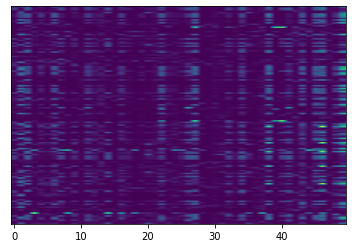

In [9]:
import matplotlib.pyplot as plt

frame = plt.gca()
frame.axes.get_yaxis().set_visible(False)
c = plt.imshow(h_im_t_mat, aspect='auto')
# c = plt.imshow(h_re_t_mat, aspect='auto')
# plt.colorbar(c)
# plt.savefig('../images/InjEx-rule_4-im.pdf', format="pdf")

In [10]:
### check if type 1 rules are followed
import numpy as np
rel = m.embeddings[1]
## get rel idx
h_list, t_list = [], []
for rule in rule_1_list:
    h_list.append(rule[0])
    t_list.append(rule[1])
print(h_list[0], t_list[0])

### get rel embeddings for all rules
idx_h = torch.LongTensor(h_list)
idx_t = torch.LongTensor(t_list)

r_h_ebds = rel(idx_h)
r_h_ebds = r_h_ebds[:, :m.rank], r_h_ebds[:, m.rank:]

r_t_ebds = rel(idx_t)
r_t_ebds = r_t_ebds[:, :m.rank], r_t_ebds[:, m.rank:]

## check by each rule
h_re_t_mat = np.zeros((len(h_list), 50),dtype=np.float64)
h_im_t_mat = np.zeros((len(h_list), 50),dtype=np.float64)
for i in range(len(h_list)):   
    h_re_t = torch.gt(r_h_ebds[0][i], r_t_ebds[0][i]).detach().numpy()
    h_re_t_mat[i,:]  = h_re_t #= np.vstack((p_lt_q,p_lt_q))
    h_im_t = (abs(r_h_ebds[1][i] - r_t_ebds[1][i])).detach().numpy()
    h_im_t_mat[i,:]  = h_im_t #= np.vstack((p_lt_q,p_lt_q))

10 12


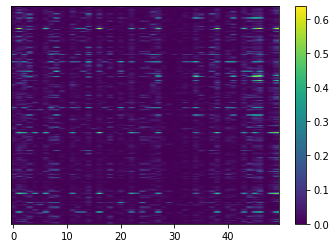

In [11]:
import matplotlib.pyplot as plt

plt.plot()
frame = plt.gca()
frame.axes.get_yaxis().set_visible(False)
c = plt.imshow(h_im_t_mat, aspect='auto')
# c = plt.imshow(h_re_t_mat, aspect='auto')
plt.colorbar(c)
# plt.savefig('../images/ComplEx-rule_0-im.pdf', format="pdf")

In [12]:
## rule_0 example
## /people/person/nationality	188 <-- /people/deceased_person/place_of_death	180
## /people/person/profession (191) <-- /people/profession/specialization_of (197)
idx_h = torch.LongTensor([191])
idx_t = torch.LongTensor([197])

r_h_ebd = np.round(rel(idx_h).detach().numpy(), 2)
r_h_ebd = r_h_ebd[:, :m.rank], r_h_ebd[:, m.rank:]

r_t_ebd = np.round(rel(idx_t).detach().numpy(), 2)
r_t_ebd = r_t_ebd[:, :m.rank], r_t_ebd[:, m.rank:]

# print(r_h_ebd)
# print(r_t_ebd)
h_re_t = (r_h_ebd[0] == r_t_ebd[0])

r_h_sel = []
r_t_sel = []
for i in range(50):
    if abs(r_t_ebd[0][0][i] - r_h_ebd[0][0][i]) <= 0.05:
        r_h_sel.append(r_h_ebd[0][0][i])
        r_t_sel.append(r_t_ebd[0][0][i])
print(r_h_sel)
print(r_t_sel)

[0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 1.0, 0.99, 0.99, 0.99, 0.99, 0.67, 0.99]
[0.98, 0.97, 0.98, 0.98, 0.96, 0.96, 0.99, 0.95, 0.98, 0.95, 0.96, 0.66, 0.97]


In [69]:
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
#     cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
#     cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.get_xaxis().set_visible(False)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)
#     ax.get_yaxis().set_visible(False)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

#     ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
#     ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im#, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

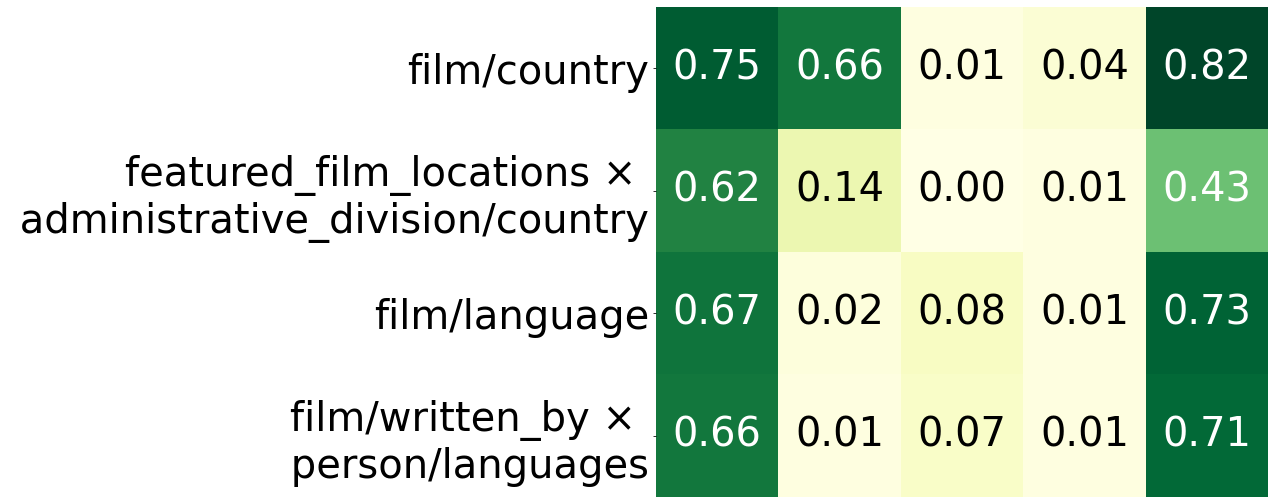

In [110]:
## real part image
import matplotlib.pyplot as plt

## /people/person/nationality	188 <-- /people/deceased_person/place_of_death	180
## /people/person/profession (191) <-- /people/profession/specialization_of (197)
# vegetables = ["/people/person/nationality", "/people/deceased_person/place_of_death", "/people/person/profession", "/people/profession/specialization_of"]
# vegetables = ["nationality", "country_of_death", "profession", "specialization_of"]
vegetables = ["film/country", "featured_film_locations × \n administrative_division/country", "film/language", "film/written_by × \n person/languages"]
farmers = ["", "", "", "", ""]

# rel0_re = np.array([[0.93, 0.01, 0.67, 0.86, 0.75],
#                     [0.93, 0.01, 0.66, 0.86, 0.74],
#                     [0.68, 0.49, 0.76, 0.49, 0.38],
#                     [0.68, 0.48, 0.74, 0.47, 0.38]])
rel4_re = np.array([[0.75, 0.66, 0.01, 0.04, 0.82],
                    [0.62, 0.14, 0.00, 0.01, 0.43],
                    [0.67, 0.02, 0.08, 0.01, 0.73],
                    [0.66, 0.01, 0.07, 0.01, 0.71]])

fig, ax = plt.subplots(figsize=(25, 8))

im = heatmap(rel4_re, vegetables, farmers, ax=ax,
                   cmap="YlGn")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.rcParams.update({'font.size': 40})
plt.savefig('../images/exp-rule_4-re.pdf', format="pdf")
plt.show()

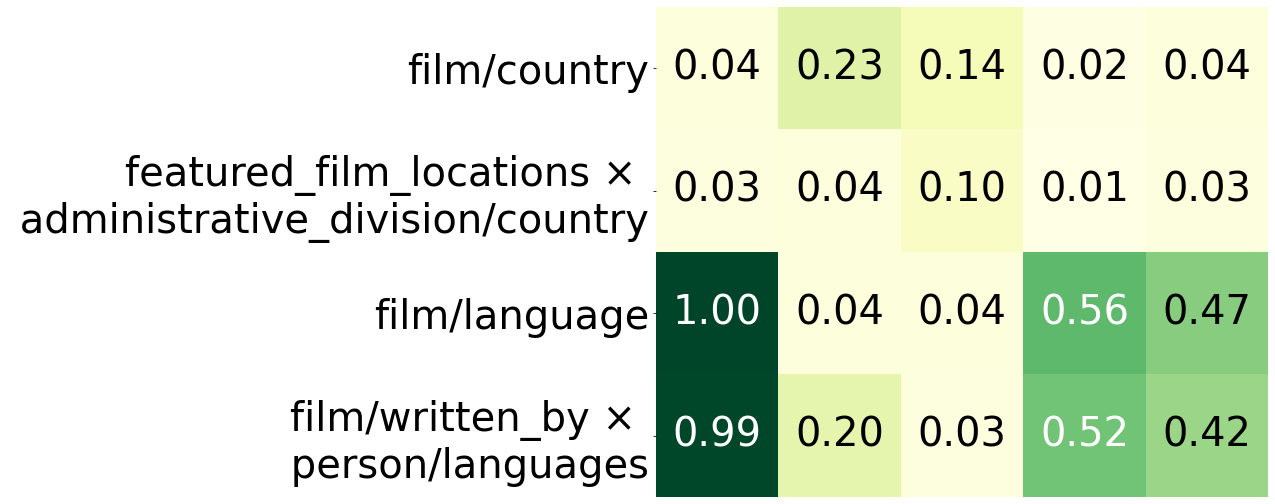

In [112]:
import matplotlib.pyplot as plt

## /people/person/nationality	188 <-- /people/deceased_person/place_of_death	180
## /people/person/profession (191) <-- /people/profession/specialization_of (197)
# vegetables = ["/people/person/nationality", "/people/deceased_person/place_of_death", "/people/person/profession", "/people/profession/specialization_of"]
# vegetables = ["nationality", "country_of_death", "profession", "specialization_of"]
# vegetables = ["/film/film/country", "/film/film/featured_film_locations", "/location/administrative_division/country", "/film/film/language", "/film/film/written_by", "/people/person/languages"]
vegetables = ["film/country", "featured_film_locations × \n administrative_division/country", "film/language", "film/written_by × \n person/languages"]
farmers = ["", "", "", "", ""]

# rel0_im = np.array([[0.01, 0.04, 0.02, 0.01, 0.23],
#                     [0.01, 0.02, 0.03, 0.01, 0.28],
#                     [0.11, 0.16, 0.02, 0.14, 0.43],
#                     [0.15, 0.20, 0.03, 0.13, 0.42]])
rel4_im = np.array([[0.04, 0.23, 0.14, 0.02, 0.04],
                    [0.03, 0.04, 0.10, 0.01, 0.03],
                    [1.0, 0.04, 0.04, 0.56, 0.47],
                    [0.99, 0.20, 0.03, 0.52, 0.42]])

fig, ax = plt.subplots(figsize=(25, 8))

im = heatmap(rel4_im, vegetables, farmers, ax=ax,
                   cmap="YlGn")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.rcParams.update({'font.size': 40})
plt.savefig('../images/exp-rule_4-im.pdf', format="pdf")
plt.show()

In [65]:
## rule_4 examples
## /film/film/country 73 <= /film/film/featured_film_locations 80,/location/administrative_division/country 118
## /film/film/language 86 <= /film/film/written_by 99,/people/person/languages 187
idx_h = torch.LongTensor([86])
idx_t1 = torch.LongTensor([99])
idx_t2 = torch.LongTensor([187])

r_h_ebd = np.round(rel(idx_h).detach().numpy(), 2)
r_h_ebd = r_h_ebd[:, :m.rank], r_h_ebd[:, m.rank:]

r_t1_ebd = np.round(rel(idx_t1).detach().numpy(), 2)
r_t1_ebd = r_t1_ebd[:, :m.rank], r_t1_ebd[:, m.rank:]

r_t2_ebd = np.round(rel(idx_t2).detach().numpy(), 2)
r_t2_ebd = r_t2_ebd[:, :m.rank], r_t2_ebd[:, m.rank:]

# print(r_h_ebd)
# print(r_t1_ebd)
# print(r_t2_ebd)

r_h_sel = []
r_t1_sel = []
r_t2_sel = []
for i in range(50):
    if 0.05 > (r_h_ebd[0][0][i] - r_t1_ebd[0][0][i] * r_t2_ebd[0][0][i]) > 0:
        r_h_sel.append(r_h_ebd[0][0][i])
        r_t1_sel.append(r_t1_ebd[0][0][i])
        r_t2_sel.append(r_t2_ebd[0][0][i])
print(r_h_sel)
print(r_t1_sel)
print(r_t2_sel)

[0.04, 0.99, 0.01, 0.98, 0.99, 0.98, 0.02, 0.99, 0.98, 0.01, 0.01, 0.01, 0.02, 0.01, 0.98, 0.02, 0.99, 0.99, 0.02, 0.02]
[0.98, 0.99, 0.95, 0.98, 0.98, 0.98, 0.98, 0.99, 0.98, 0.99, 0.97, 0.99, 0.74, 0.97, 0.98, 0.65, 0.97, 0.97, 0.0, 0.97]
[0.0, 0.98, 0.0, 0.99, 0.97, 0.98, 0.0, 0.98, 0.99, 0.0, 0.0, 0.0, 0.0, 0.0, 0.99, 0.0, 0.98, 0.98, 0.0, 0.0]


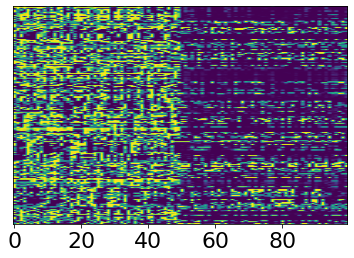

In [27]:
### entity embeddings
ent = m.embeddings[0].weight.data
rel_ebd = m.embeddings[1].weight.data

# ent = ent[:, :m.rank], ent[:, m.rank:]

plt.plot()
frame = plt.gca()
frame.axes.get_yaxis().set_visible(False)
c = plt.imshow(rel_ebd, aspect='auto')
# c = plt.imshow(h_re_t_mat, aspect='auto')
# plt.colorbar(c)
plt.savefig('../images/InjEx-ent-1.pdf', format="pdf")